# 🤔 Can You Predict the Stock Market with Machine Learning? 

Hey! In this notebook, we’re diving into predicting stock prices using Python. We’ll grab historical data, engineer some handy features, and build a few machine learning models like XGBoost, LightGBM, and a neural network. Our goal is to forecast future stock prices as accurately as possible while keeping things realistic.

But first, a quick reality check: modeling stock prices is extremely difficult in practice. The market is influenced by countless factors like news, macroeconomic trends, investor sentiment, and random events (most of which are not captured in historical price data alone). Even advanced models can struggle to consistently outperform simple baselines.

This notebook is intended as a beginner-to-intermediate learning resource. It simplifies many parts of the real process. For example, in production-level workflows you'd typically need to:

- Incorporate more diverse data (like fundamentals, news, or technical indicators)
- Handle non-stationarity in time series data
- Evaluate models with more robust techniques (like walk-forward validation)
- Consider transaction costs, slippage, and risk metrics
- Avoid lookahead bias and data leakage

Here, we’re focusing on building intuition, not building a hedge fund 😅. Along the way, we’ll touch on core ideas like data prep, feature engineering, model training, and performance evaluation, all in a beginner-friendly and hands-on way.

# 🔍 Data Inspection

### Fetching Stock Data with yFinance

Here, we're grabbing historical stock data for Apple (AAPL) from the start of 2000 up until May 31, 2025 using the `yfinance` library. 

The `yf.download` function makes it super easy to pull data like open, high, low, close prices, and trading volume, which are the key basics we need for most stock analysis or prediction tasks.

We then narrow down the DataFrame to only the columns we care about: Open, High, Low, Close, and Volume, the essential price and volume info that will feed into our model later on.

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np

ticker = "AAPL"
df = yf.download(ticker, start="2000-01-01", end="2025-05-31")
df = df[["Open", "High", "Low", "Close", "Volume"]]

C:\Users\Marwane\AppData\Local\Temp\ipykernel_53104\152401808.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2000-01-01", end="2025-05-31")
[*********************100%***********************]  1 of 1 completed


## Peek at our Data

In [169]:
display(df.head(), df.tail(), df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6391 entries, 2000-01-03 to 2025-05-30
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Open, AAPL)    6391 non-null   float64
 1   (High, AAPL)    6391 non-null   float64
 2   (Low, AAPL)     6391 non-null   float64
 3   (Close, AAPL)   6391 non-null   float64
 4   (Volume, AAPL)  6391 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 299.6 KB


Price,Open,High,Low,Close,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2000-01-03,0.787983,0.845274,0.764034,0.841048,535796800
2000-01-04,0.813341,0.831186,0.760277,0.770139,512377600
2000-01-05,0.779530,0.830716,0.773895,0.781409,778321600
2000-01-06,0.797375,0.803949,0.713787,0.713787,767972800
2000-01-07,0.725057,0.758868,0.717544,0.747598,460734400


Price,Open,High,Low,Close,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-05-23,193.669998,197.699997,193.460007,195.270004,78432900
2025-05-27,198.300003,200.740005,197.429993,200.210007,56288500
2025-05-28,200.589996,202.729996,199.899994,200.419998,45339700
2025-05-29,203.580002,203.809998,198.509995,199.949997,51396800
2025-05-30,199.369995,201.960007,196.779999,200.850006,70819900


None

### Understanding the Data Structure

The data we pulled contains 6,391 rows, ranging from January 3, 2000, to May 30, 2025. Each row represents one trading day.

There are 5 columns: Open, High, Low, Close, and Volume. These columns have no missing values, so the dataset is clean.

- The first 4 columns hold floating-point numbers representing the stock prices during the day.
- The Volume column is an integer showing how many shares were traded that day.

This is a typical structure for historical stock data and forms the foundation for building any predictive model.

## Basic Statistical Analysis on Data

In [170]:
from scipy.stats import skew, kurtosis

def better_summary(df):
    summary_data = []

    for col in df.columns:
        col_data = df[col]
        col_summary = {
            "Column": col,
            "Data Type": col_data.dtype,
            "Non-Null Count": col_data.notnull().sum(),
            "Missing Count": col_data.isnull().sum(),
            "Missing %": col_data.isnull().mean() * 100,
            "Unique Count": col_data.nunique()
        }

        if pd.api.types.is_numeric_dtype(col_data):
            col_summary.update({
                "Min": col_data.min(),
                "Max": col_data.max(),
                "Mean": col_data.mean(),
                "Median": col_data.median(),
                "Std Dev": col_data.std(),
                "Skewness": skew(col_data.dropna()),
                "Kurtosis": kurtosis(col_data.dropna())
            })
        else:
            mode = col_data.mode().iloc[0] if not col_data.mode().empty else np.nan
            mode_freq = col_data.value_counts().iloc[0] if not col_data.value_counts().empty else np.nan
            col_summary.update({
                "Top (Mode)": mode,
                "Freq": mode_freq
            })

        summary_data.append(col_summary)

    return pd.DataFrame(summary_data).style.format(precision=2).background_gradient(cmap="Blues")

summary = better_summary(df)
summary

,Column,Data Type,Non-Null Count,Missing Count,Missing %,Unique Count,Min,Max,Mean,Median,Std Dev,Skewness,Kurtosis
0,"('Open', 'AAPL')",float64,6391,0,0.00,6388,0.20,257.57,44.00,14.77,63.62,1.60,1.25
1,"('High', 'AAPL')",float64,6391,0,0.00,6390,0.20,259.47,44.48,14.98,64.32,1.59,1.24
2,"('Low', 'AAPL')",float64,6391,0,0.00,6382,0.19,257.01,43.55,14.66,62.97,1.60,1.26
3,"('Close', 'AAPL')",float64,6391,0,0.00,5978,0.20,258.40,44.04,14.83,63.69,1.60,1.25
4,"('Volume', 'AAPL')",int64,6391,0,0.00,6359,23234700.00,7421640800.00,380696961.07,260556800.00,382877177.31,2.97,23.85


Here's a snapshot of the main characteristics for each column in our Apple stock data:

- **No missing values:** Every day has complete data, so no need for filling gaps.
- **Unique counts:** Most price columns have nearly as many unique values as rows, meaning prices vary daily.
- **Price ranges:**  
  - Open prices range roughly from $0.20 to $257.57  
  - High, Low, and Close prices have similar ranges, reflecting normal daily fluctuations.
- **Volume is huge and variable:**  
  - Ranges from about 23 million to over 7.4 billion shares traded, with a very high standard deviation.  
  - The distribution is highly skewed, meaning some days have massive trading spikes.
- **Skewness and Kurtosis:**  
  - Prices are moderately skewed and have slight tails heavier than a normal distribution, typical for financial data.  
  - Volume is heavily skewed and has extreme peaks, reflecting volatile trading activity on certain days.

Understanding these stats helps in preparing data and selecting models that can handle such real-world financial quirks.

## Preliminar Feature Engineering

### Feature Engineering: Making the Data More Informative

To help our model understand the stock behavior better, we create new features from the raw data:

- **Renaming columns:** Simplifies names for easier reference (`open`, `high`, `low`, `close`, `volume`).

- **Returns:**  
  - `return_1d`: Daily return (percentage change from previous day).  
  - `return_5d`: Return over 5 days, capturing short-term trends.

- **Volatility:**  
  - `volatility_5d` and `volatility_10d`: Rolling standard deviations of daily returns, measuring recent price variability.

- **Moving averages (MA):**  
  - `ma_5` and `ma_10`: 5-day and 10-day average closing prices, smoothing out daily noise.  
  - `ma_ratio_5_10`: Ratio of short-term to longer-term MA, useful for trend signals.

- **Price range & price movement:**  
  - `price_range`: Daily high-low range normalized by open price, showing intraday volatility.  
  - `open_close_diff`: Normalized difference between close and open prices, indicating price direction within the day.

- **Volume features:**  
  - `volume_change`: Daily percentage change in volume, capturing shifts in trading activity.  
  - `rolling_volume_5d`: 5-day average volume for smoothing.

- **Lag features:**  
  - Previous day's closing price (`lag_close_1`), two days prior (`lag_close_2`), and previous day’s return (`lag_return_1`) to incorporate recent history.

- **Cleaning:** Remove any rows with missing values caused by rolling calculations or shifts.

These engineered features give the model richer context beyond raw prices, improving its ability to detect patterns and predict future prices.

In [ ]:
df.columns = ['_'.join(col).strip() for col in df.columns.values]

df = df.rename(columns={
    'Open_AAPL': 'open',
    'High_AAPL': 'high',
    'Low_AAPL': 'low',
    'Close_AAPL': 'close',
    'Volume_AAPL': 'volume'
})

df['return_1d'] = df['close'].pct_change()
df['return_5d'] = df['close'].pct_change(5)
df['volatility_5d'] = df['return_1d'].rolling(window=5).std()
df['volatility_10d'] = df['return_1d'].rolling(window=10).std()

df['ma_5'] = df['close'].rolling(window=5).mean()
df['ma_10'] = df['close'].rolling(window=10).mean()
df['ma_ratio_5_10'] = df['ma_5'] / df['ma_10']

df['price_range'] = (df['high'] - df['low']) / df['open']
df['open_close_diff'] = (df['close'] - df['open']) / df['open']
df['volume_change'] = df['volume'].pct_change()
df['rolling_volume_5d'] = df['volume'].rolling(window=5).mean()

df['lag_close_1'] = df['close'].shift(1)
df['lag_close_2'] = df['close'].shift(2)
df['lag_return_1'] = df['return_1d'].shift(1)

df = df.dropna()

### How does our data look like now?

In [172]:
display(df.head(), df.tail(), df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6381 entries, 2000-01-18 to 2025-05-30
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   open               6381 non-null   float64
 1   high               6381 non-null   float64
 2   low                6381 non-null   float64
 3   close              6381 non-null   float64
 4   volume             6381 non-null   int64  
 5   return_1d          6381 non-null   float64
 6   return_5d          6381 non-null   float64
 7   volatility_5d      6381 non-null   float64
 8   volatility_10d     6381 non-null   float64
 9   ma_5               6381 non-null   float64
 10  ma_10              6381 non-null   float64
 11  ma_ratio_5_10      6381 non-null   float64
 12  price_range        6381 non-null   float64
 13  open_close_diff    6381 non-null   float64
 14  volume_change      6381 non-null   float64
 15  rolling_volume_5d  6381 non-null   float64
 16  lag_cl

,open,high,low,close,volume,return_1d,return_5d,volatility_5d,volatility_10d,ma_5,ma_10,ma_ratio_5_10,price_range,open_close_diff,volume_change,rolling_volume_5d,lag_close_1,lag_close_2,lag_return_1
Date,,,,,,,,,,,,,,,,,,,
2000-01-18,0.758868,0.796436,0.754642,0.780939,459177600,0.034848,0.063299,0.070509,0.064955,0.722897,0.736187,0.981948,0.055075,0.029083,0.176244,659971200.0,0.754641,0.726935,0.038113
2000-01-19,0.793618,0.817098,0.776713,0.800662,597643200,0.025256,0.148922,0.060321,0.059165,0.743653,0.739239,1.005971,0.050888,0.008876,0.301551,691190080.0,0.780939,0.754641,0.034848
2000-01-20,0.867815,0.912896,0.852788,0.852788,1831132800,0.065103,0.301792,0.034157,0.062113,0.783193,0.746377,1.049327,0.069263,-0.017316,2.063923,862202880.0,0.800662,0.780939,0.025256
2000-01-21,0.858422,0.858422,0.827899,0.836352,495924800,-0.019273,0.150517,0.030679,0.053477,0.805076,0.758633,1.061219,0.035558,-0.025711,-0.729170,754850880.0,0.852788,0.800662,0.065103
2000-01-24,0.814750,0.847152,0.789862,0.798315,440876800,-0.045480,0.057873,0.044158,0.055680,0.813811,0.763705,1.065609,0.070317,-0.020173,-0.111001,764951040.0,0.836352,0.852788,-0.019273


,open,high,low,close,volume,return_1d,return_5d,volatility_5d,volatility_10d,ma_5,ma_10,ma_ratio_5_10,price_range,open_close_diff,volume_change,rolling_volume_5d,lag_close_1,lag_close_2,lag_return_1
Date,,,,,,,,,,,,,,,,,,,
2025-05-23,193.669998,197.699997,193.460007,195.270004,78432900,-0.030244,-0.075689,0.010836,0.025348,202.872000,207.311998,0.978583,0.021893,0.008262,0.677982,54604840.0,201.360001,202.089996,-0.003612
2025-05-27,198.300003,200.740005,197.429993,200.210007,56288500,0.025298,-0.041048,0.021511,0.015628,201.158002,206.253999,0.975293,0.016692,0.009632,-0.282336,56634440.0,195.270004,201.360001,-0.030244
2025-05-28,200.589996,202.729996,199.899994,200.419998,45339700,0.001049,-0.031132,0.021873,0.014894,199.870001,205.003000,0.974961,0.014108,-0.000847,-0.194512,57203060.0,200.210007,195.270004,0.025298
2025-05-29,203.580002,203.809998,198.509995,199.949997,51396800,-0.002345,-0.010589,0.019716,0.014906,199.442001,203.764999,0.978784,0.026034,-0.017831,0.133594,55640060.0,200.419998,200.210007,0.001049
2025-05-30,199.369995,201.960007,196.779999,200.850006,70819900,0.004501,-0.002533,0.019881,0.015265,199.340002,202.705000,0.983400,0.025982,0.007423,0.377905,60455560.0,199.949997,200.419998,-0.002345


None

# 📊 Data Analysis and Visualization

### Visualizing Stock Data & Features: What’s Happening Over Time?

Here we use line charts and a heatmap to get a feel for the data patterns:

- **Price with Moving Averages:**  
  Plotting the closing price along with 5-day and 10-day moving averages helps us see trends and smoothing effects.  
  Moving averages filter out daily noise and hint at momentum shifts.

- **Rolling Volatility:**  
  Visualizing 5-day and 10-day volatility shows how price swings fluctuate over time, highlighting calm vs. turbulent periods.

- **Returns:**  
  Daily (`return_1d`) and 5-day returns (`return_5d`) plots reveal how the stock gains or loses value, showing the frequency and magnitude of changes.

- **Price Range (% of Open):**  
  Daily high-low range as a percent of the opening price indicates intraday volatility, a key signal for traders.

- **Feature Correlation Matrix:**  
  Heatmap of feature correlations uncovers relationships among variables.  
  For example, moving averages strongly correlate with the closing price, while volatility features may have weaker or negative correlations.

These visuals are crucial for understanding the data behavior before diving into modeling, helping to spot trends, seasonality, or anomalies.

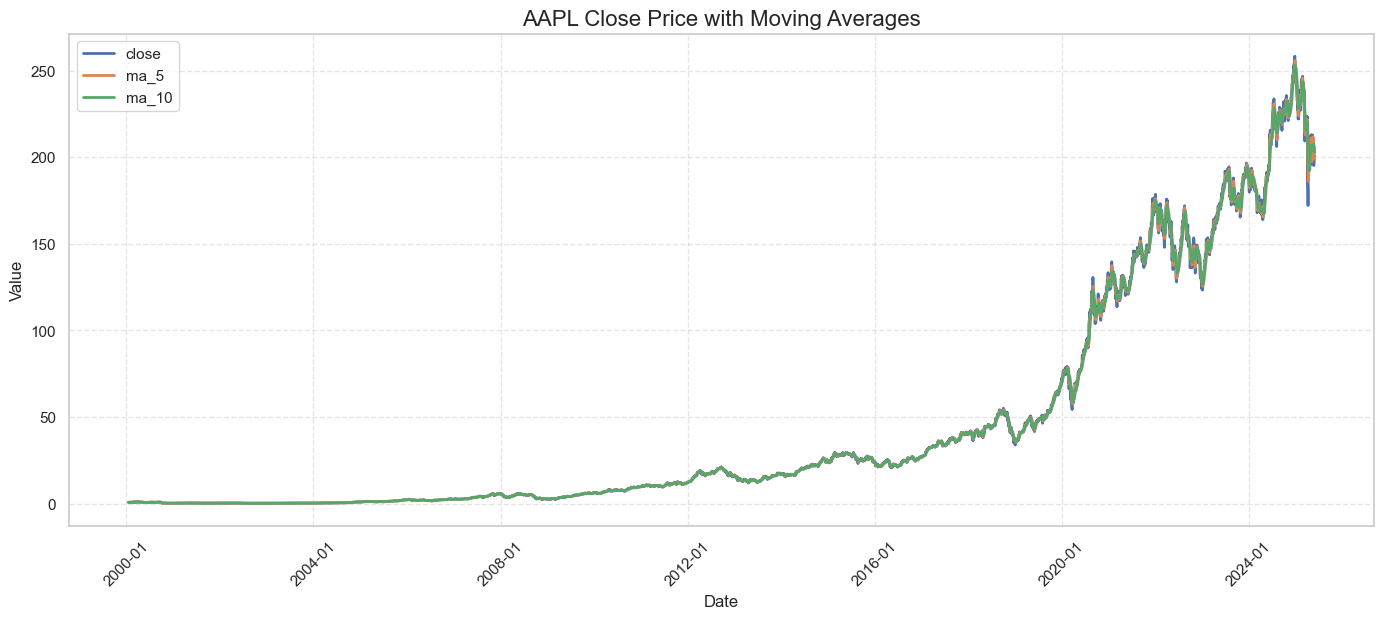

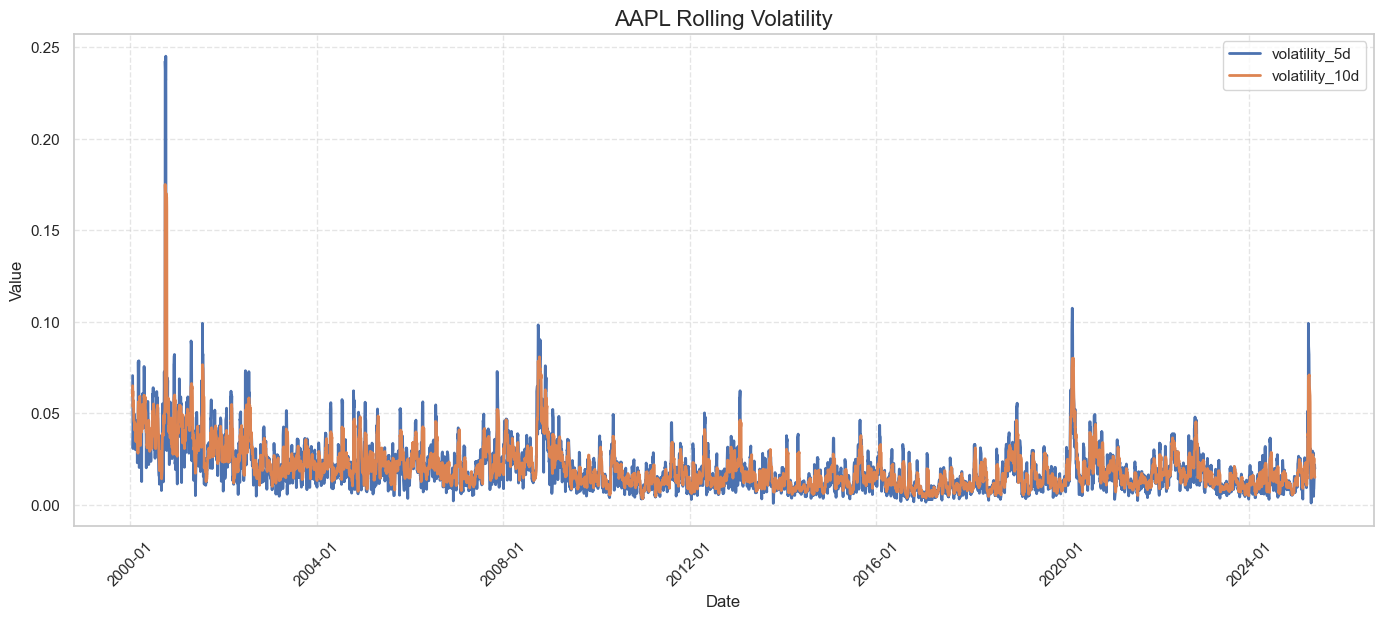

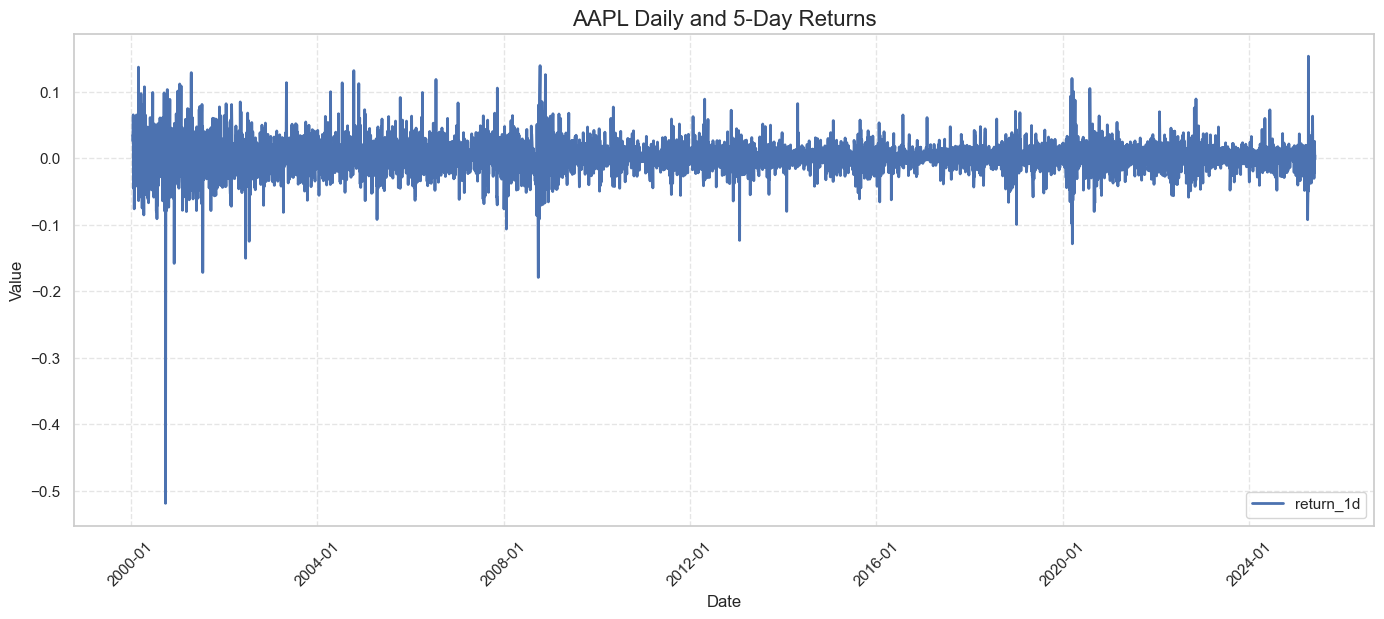

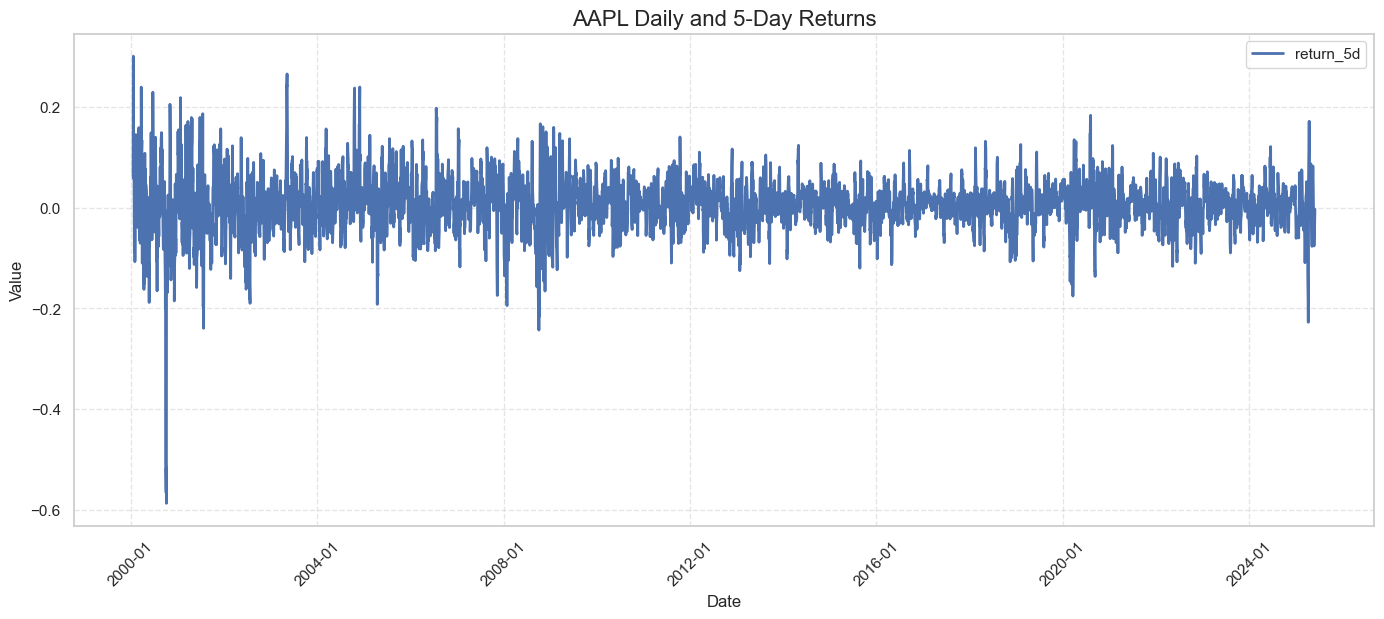

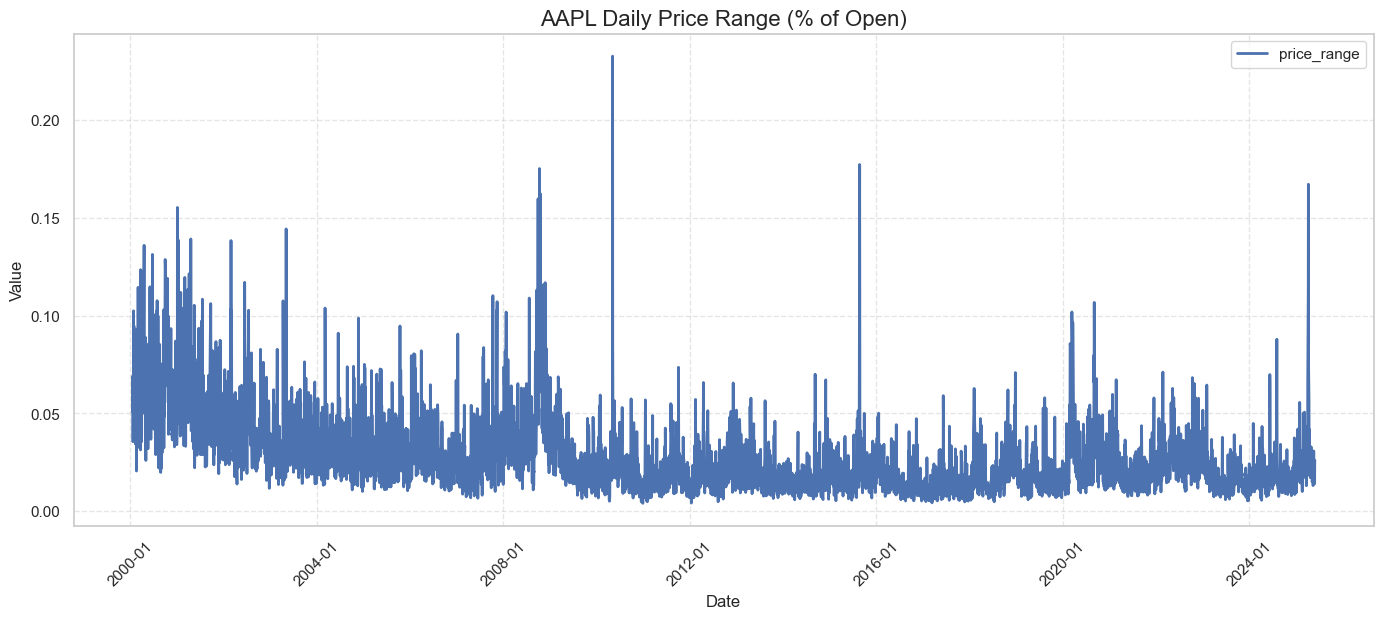

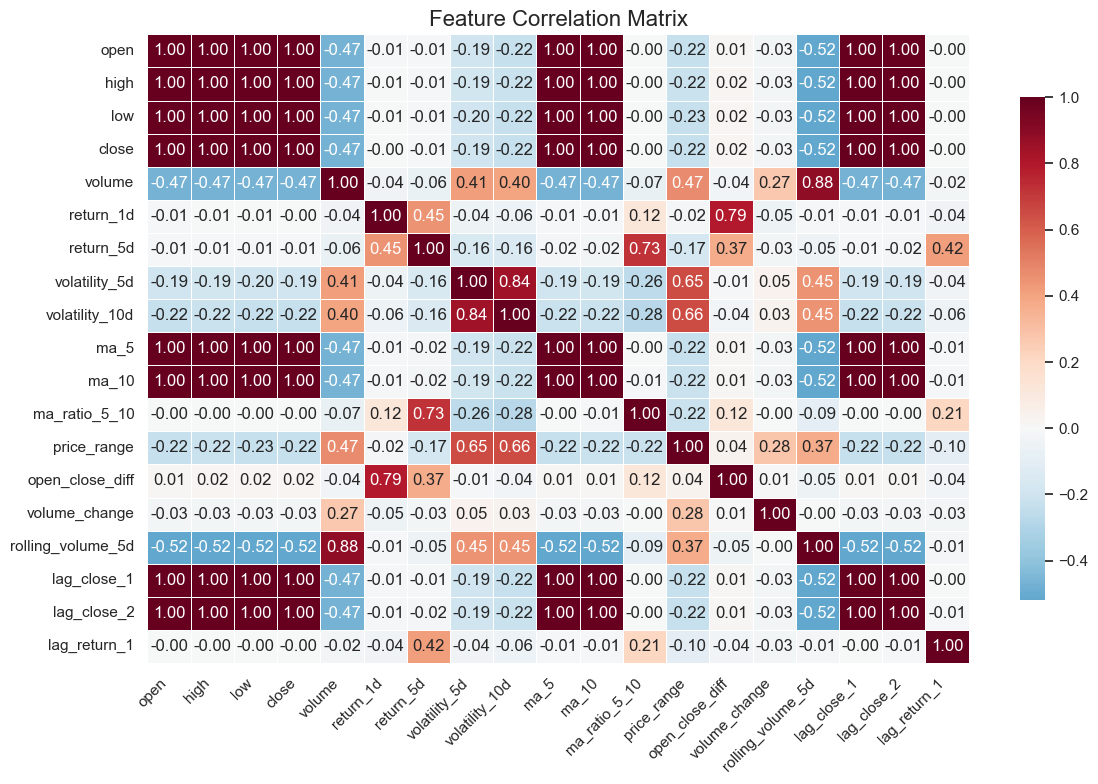

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

sns.set_theme(style='whitegrid')

def plot_financial_series(df, columns, title):
    plt.figure(figsize=(14, 6))
    for col in columns:
        plt.plot(df.index, df[col], label=col, linewidth=2)
    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.show()

plot_financial_series(df, ['close', 'ma_5', 'ma_10'], 'AAPL Close Price with Moving Averages')

plot_financial_series(df, ['volatility_5d', 'volatility_10d'], 'AAPL Rolling Volatility')

plot_financial_series(df, ['return_1d'], 'AAPL Daily and 5-Day Returns')

plot_financial_series(df, ['return_5d'], 'AAPL Daily and 5-Day Returns')

plot_financial_series(df, ['price_range'], 'AAPL Daily Price Range (% of Open)')

plt.figure(figsize=(12, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='RdBu_r', center=0, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Feature Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Add Complexity on Features

### Adding Relative Strength Index (RSI) – A Popular Momentum Indicator

The RSI measures how strong recent price gains are compared to losses, giving a value between 0 and 100:

- **How it works:**  
  It calculates average gains and losses over a set period (14 days here), then derives a ratio (RS) of these averages.  
  Finally, RSI transforms this ratio into a score where:  
  - Above 70 usually means the stock is overbought (potentially overvalued, may drop).  
  - Below 30 usually means oversold (potentially undervalued, may rise).

- **Why add RSI?**  
  It’s a widely used technical indicator that helps models detect momentum shifts and potential reversals, which raw price data alone might miss.

- **Implementation details:**  
  We compute daily price changes (`delta`), separate positive gains and losses, smooth them with a rolling average, and calculate RSI using the standard formula.

By including RSI, the model gets richer insight into the stock's momentum and market sentiment.

In [ ]:
# Relative Strength Index (RSI)
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['rsi_14'] = compute_rsi(df['close'], 14)

### Moving Average Convergence Divergence (MACD) Explained

MACD is a popular technical indicator that helps identify momentum changes and trend direction in stock prices.

- **What it is:**  
  It calculates the difference between two Exponential Moving Averages (EMAs) — a faster one (12 days) and a slower one (26 days).  
  This difference is the MACD line.

- **Signal Line:**  
  A 9-day EMA of the MACD line that smooths out the fluctuations, acting as a trigger for buy/sell signals.

- **Histogram:**  
  The difference between the MACD line and the signal line, showing momentum strength visually.  
  When the histogram crosses zero or changes direction, it hints at possible trend reversals.

- **Why use MACD?**  
  It captures both trend and momentum information, which can be crucial for predicting stock price movements beyond just raw prices.

By adding MACD features, the model can better understand shifts in trend strength and timing.

In [ ]:
# Moving Average Convergence Divergence (MACD)
def compute_macd(series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    histogram = macd - signal_line
    return macd, signal_line, histogram

df['macd'], df['macd_signal'], df['macd_hist'] = compute_macd(df['close'])

### Bollinger Bands: What and Why

Bollinger Bands are a classic tool for understanding price volatility and potential reversal points.

- **How it works:**  
  It uses a moving average (usually 20 days) as the middle line, and then creates an upper and lower band a certain number of standard deviations (commonly 2) away from that average.

- **Upper Band:**  
  The moving average plus two times the rolling standard deviation. This represents a "high" boundary.

- **Lower Band:**  
  The moving average minus two times the rolling standard deviation. This acts as a "low" boundary.

- **What it tells us:**  
  When prices touch or move outside the bands, it suggests the stock might be overbought or oversold, signaling possible reversals or pullbacks.

- **Why add Bollinger Bands as features?**  
  They give the model a sense of price extremes and volatility, helping it spot moments when prices could change direction.

In [ ]:
# Bollinger Bands
def bollinger_bands(series, window=20, num_std=2):
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return upper_band, lower_band

df['bb_upper'], df['bb_lower'] = bollinger_bands(df['close'])

### Average True Range (ATR): Understanding Volatility

ATR measures market volatility by calculating the average of true ranges over a given period (commonly 14 days).

- **True Range:**  
  It’s the greatest of these three values for each day:  
  1. Current high minus current low  
  2. Absolute value of current high minus previous close  
  3. Absolute value of current low minus previous close

- **Why True Range?**  
  It captures gaps and limits that simple high-low ranges might miss, giving a more accurate volatility picture.

- **ATR Calculation:**  
  The rolling average of the true range over the specified period smooths out daily fluctuations to show general volatility trends.

- **Usefulness:**  
  ATR helps the model understand how “wild” the price movements are, which can be crucial for risk assessment and timing predictions.

In [ ]:
# Average True Range (ATR)
def compute_atr(df, period=14):
    high_low = df['high'] - df['low']
    high_close_prev = np.abs(df['high'] - df['close'].shift())
    low_close_prev = np.abs(df['low'] - df['close'].shift())
    true_range = pd.concat([high_low, high_close_prev, low_close_prev], axis=1).max(axis=1)
    atr = true_range.rolling(window=period).mean()
    return atr

df['atr_14'] = compute_atr(df)

### Volume Features: Adding Depth to Price Action

**Volume Spikes**  
This looks at how current trading volume compares to the recent average volume (usually 20 days).  
- When volume suddenly jumps way above average, it often means strong buying or selling interest.

**Volume Weighted Average Price (VWAP)**  
VWAP gives an average price weighted by volume throughout the trading period.  
- It’s like the "fair" price considering how much stock was traded at each price point.  
- Traders use VWAP to understand the overall market sentiment and whether prices are high or low relative to volume flow.

**Why add these?**  
Volume tells us *how* much interest there is behind price moves. Together, these features help the model grasp when a price move is backed by real trading power, improving prediction quality.

In [ ]:
# Volume spikes (ratio of current volume to rolling average volume)
df['vol_avg_20'] = df['volume'].rolling(window=20).mean()
df['vol_spike'] = df['volume'] / df['vol_avg_20']

# Volume Weighted Average Price (VWAP)
def compute_vwap(df):
    cum_vol = df['volume'].cumsum()
    cum_vol_price = (df['close'] * df['volume']).cumsum()
    vwap = cum_vol_price / cum_vol
    return vwap

df['vwap'] = compute_vwap(df)

### Adding Time and Holiday Features: Capturing Calendar Effects

- **Day of Week, Month, Day of Month:**  
  Stock behavior often varies by time. For example, Mondays can be more volatile, certain months might have seasonal trends, and specific days in a month could show patterns.  
  Adding these as features lets the model pick up on these calendar-related effects.

- **Holiday Indicator:**  
  Stock markets close on holidays, and trading days near holidays often have unusual volume or price behavior.  
  Marking holidays helps the model understand these special cases and avoid confusion from missing or irregular data.

Including these time-based and holiday signals helps the model better mimic real market rhythms.

In [ ]:
df['day_of_week'] = df.index.dayofweek     
df['month'] = df.index.month
df['day_of_month'] = df.index.day

import holidays
us_holidays = holidays.US()
df['is_holiday'] = df.index.to_series().apply(lambda x: 1 if x in us_holidays else 0)

df = df.dropna()

## Visualize New Features

Here, we create clean, finance-style plots to better understand our features:

- **RSI (Relative Strength Index):**  
  Shows when the stock might be overbought or oversold, helping spot potential reversals.

- **MACD (Moving Average Convergence Divergence):**  
  Includes the MACD line, signal line, and histogram — classic momentum indicators to capture trend strength and changes.

- **Bollinger Bands:**  
  Plots the close price with upper and lower bands representing volatility. Price touching or crossing bands signals possible entry or exit points.

- **ATR (Average True Range):**  
  Measures market volatility — higher ATR means more price movement, useful for risk management.

- **Volume Spike & VWAP:**  
  Highlights sudden volume surges and the volume-weighted average price, indicating strong buying/selling activity and fair price level.

- **Date/Time Feature Distributions:**  
  Histograms show how often certain days of the week, months, and days of the month appear — important for capturing calendar effects in the data.

These visuals help us intuitively grasp the behavior and quality of our engineered features before feeding them into models.

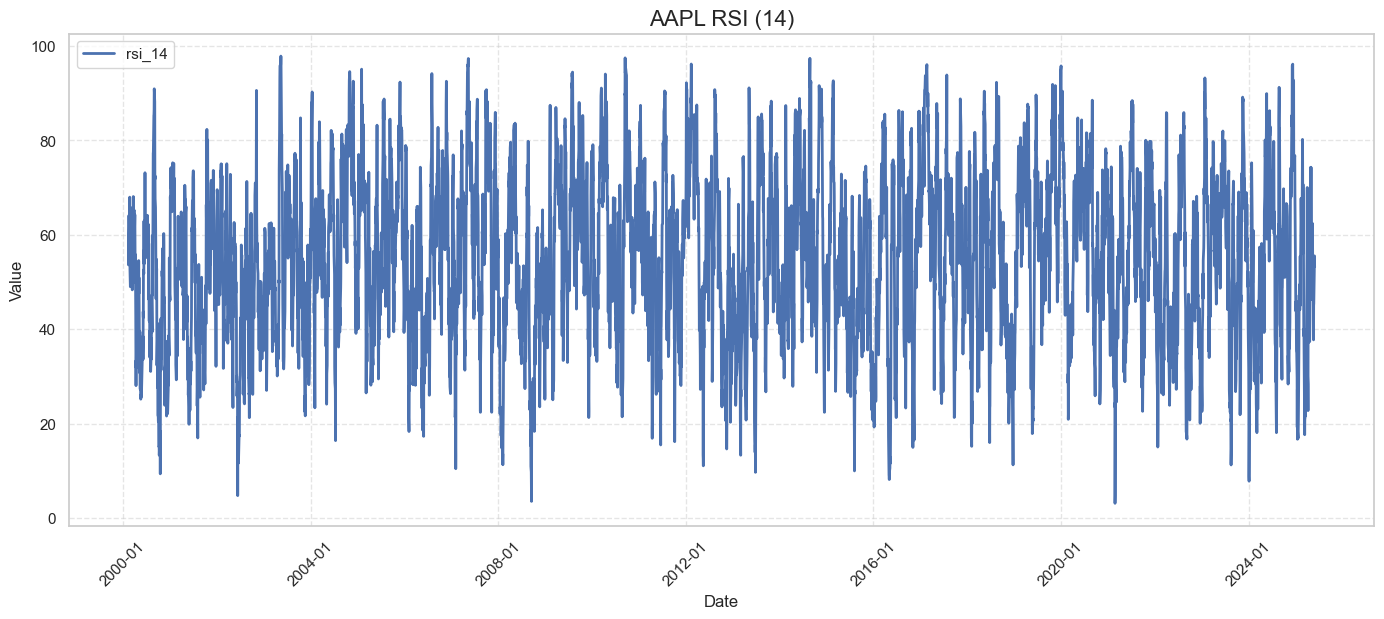

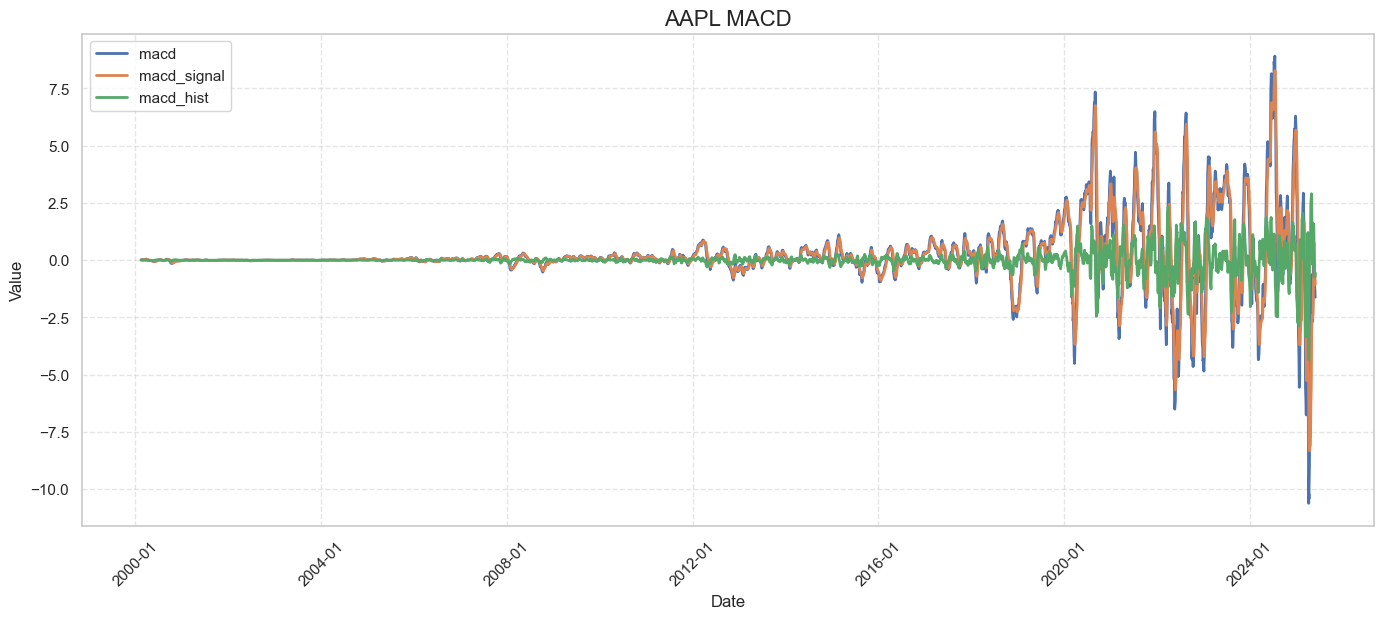

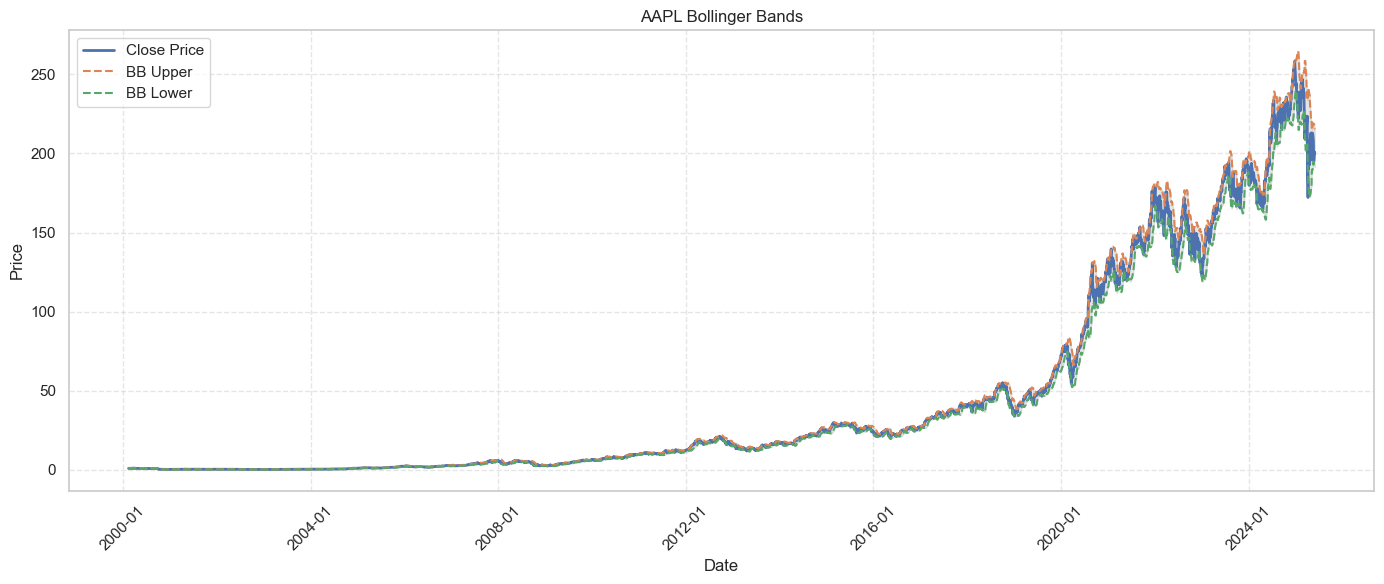

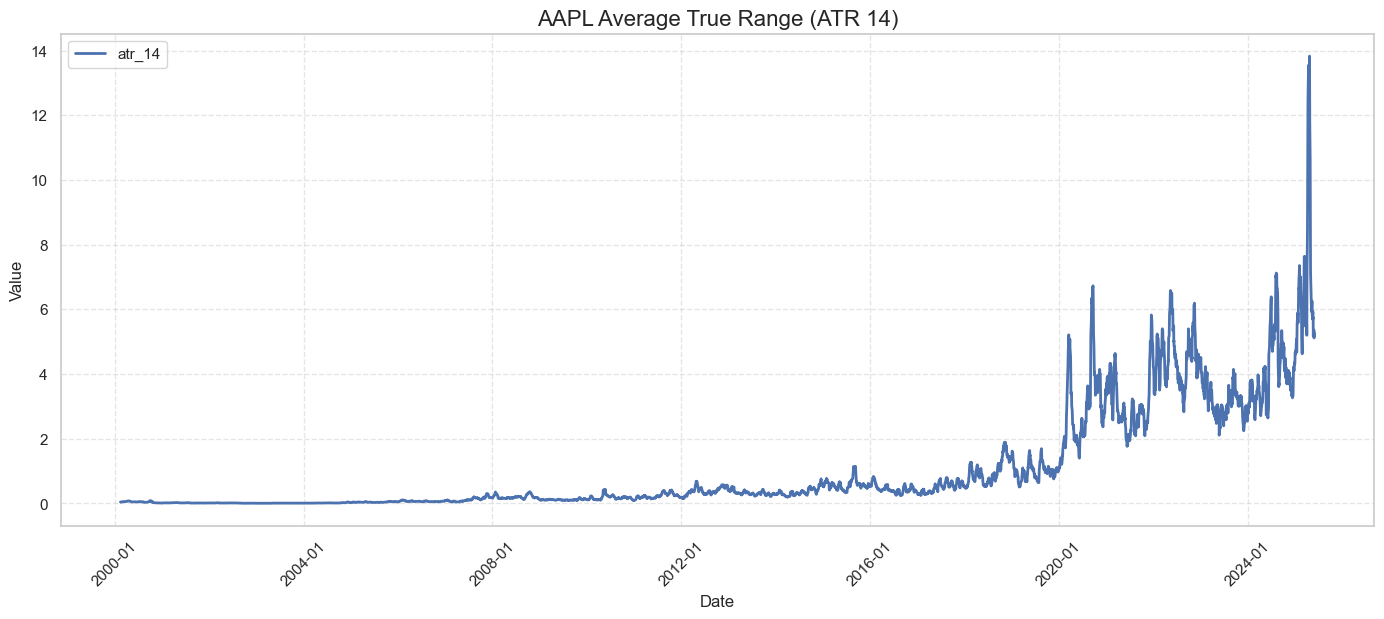

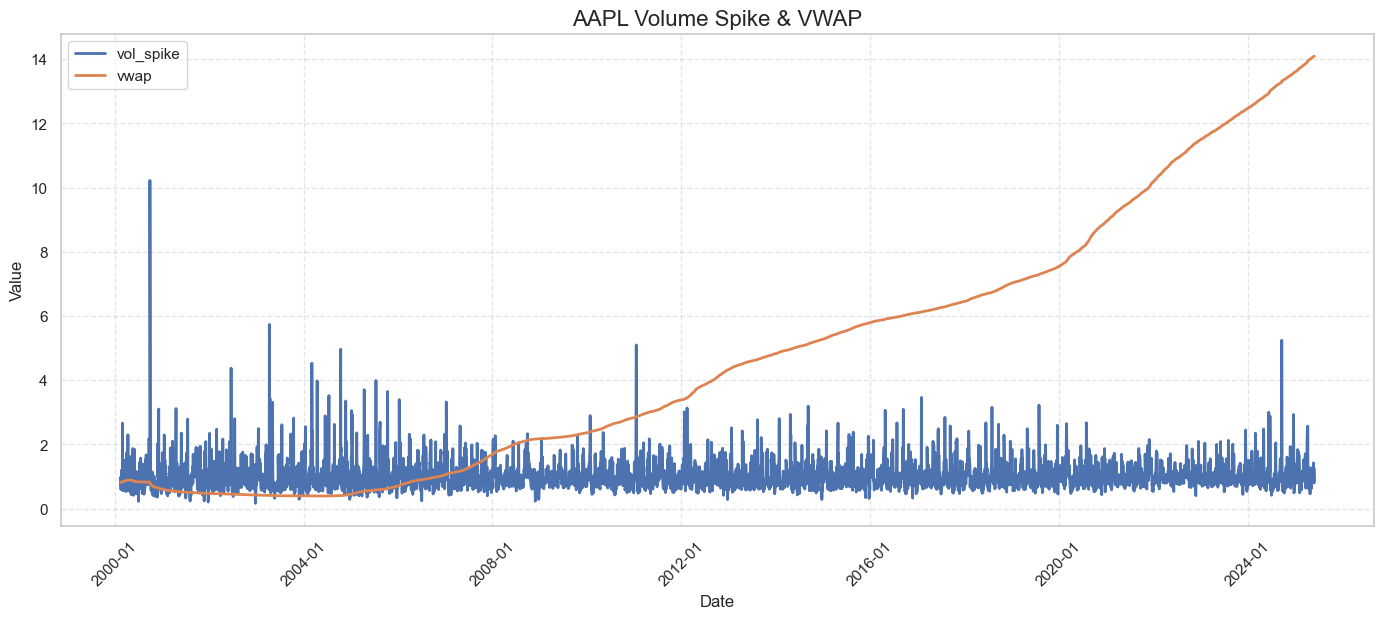

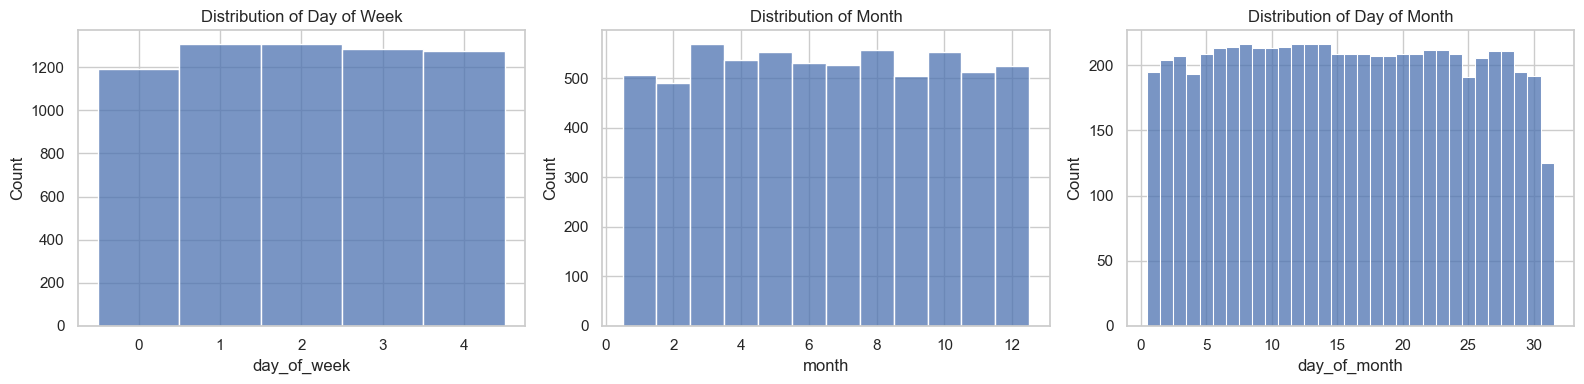

In [ ]:
sns.set_theme(style='whitegrid')

def plot_financial_series(df, columns, title, figsize=(14,6)):
    plt.figure(figsize=figsize)
    for col in columns:
        plt.plot(df.index, df[col], label=col, linewidth=2)
    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.show()

plot_financial_series(df, ['rsi_14'], "AAPL RSI (14)")

plot_financial_series(df, ['macd', 'macd_signal', 'macd_hist'], "AAPL MACD")

plt.figure(figsize=(14,6))
plt.plot(df.index, df['close'], label='Close Price', linewidth=2)
plt.plot(df.index, df['bb_upper'], label='BB Upper', linestyle='--')
plt.plot(df.index, df['bb_lower'], label='BB Lower', linestyle='--')
plt.fill_between(df.index, df['bb_lower'], df['bb_upper'], color='gray', alpha=0.2)
plt.title("AAPL Bollinger Bands")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plot_financial_series(df, ['atr_14'], "AAPL Average True Range (ATR 14)")

plot_financial_series(df, ['vol_spike', 'vwap'], "AAPL Volume Spike & VWAP")

fig, axes = plt.subplots(1, 3, figsize=(16,4))
sns.histplot(df['day_of_week'], bins=7, discrete=True, ax=axes[0])
axes[0].set_title('Distribution of Day of Week')
sns.histplot(df['month'], bins=12, discrete=True, ax=axes[1])
axes[1].set_title('Distribution of Month')
sns.histplot(df['day_of_month'], bins=31, discrete=True, ax=axes[2])
axes[2].set_title('Distribution of Day of Month')
plt.tight_layout()
plt.show()


# 🧠 Modeling

### Setting Up the Environment for Stock Prediction

Here's what we're importing and why:

- **Scaling and Feature Engineering:**  
  `StandardScaler` normalizes features for better model performance. `PolynomialFeatures` can create interaction terms to help capture non-linear relationships.

- **Machine Learning Models:**  
  We use powerful models like XGBoost (`XGBRegressor`), LightGBM (`lgb.LGBMRegressor`), and Gradient Boosting (`GradientBoostingRegressor`) — all great at handling complex patterns in tabular data.

- **Neural Networks:**  
  Using Keras (`Sequential`, `Dense`, `Dropout`, `EarlyStopping`) to build flexible deep learning models that can learn intricate relationships.

- **Model Validation:**  
  `TimeSeriesSplit` respects the time order in data, crucial for stock prediction to avoid look-ahead bias.

In [ ]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from xgboost import XGBRegressor
import lightgbm as lgb

[*********************100%***********************]  1 of 1 completed


### Creating Simple Features for Stock Prediction

Here, we add a few straightforward but powerful features to help our model understand recent price movements:

- **1-day Return (`return_1d`)**:  
  Percentage change in closing price compared to the previous day — a quick snapshot of daily momentum.

- **Lagged Close Prices (`lag_close_1`, `lag_close_2`)**:  
  Closing prices from 1 and 2 days ago, so the model can see recent history and trends.

- **Lagged Return (`lag_return_1`)**:  
  The previous day's return, which helps capture short-term momentum continuity.

Dropping missing values ensures we only keep rows where these features have valid data. These basics form a foundation for more complex modeling later.

In [ ]:
ticker = "AAPL"
df = yf.download(ticker, start="2000-01-01", end="2025-06-19").dropna()

def add_features(df):
    df['return_1d'] = df['Close'].pct_change()
    df['lag_close_1'] = df['Close'].shift(1)
    df['lag_close_2'] = df['Close'].shift(2)
    df['lag_return_1'] = df['return_1d'].shift(1)
    return df.dropna()

df = add_features(df)

### Why Not Use All Engineered Features?

While adding tons of features might seem like it will help the model, it often backfires due to **overfitting** — when the model learns the noise or quirks of the training data instead of the underlying patterns.

Overfitting leads to great performance on training data but poor generalization to new, unseen data (like future stock prices). By limiting features to just a few meaningful ones, we reduce complexity, help the model focus on the most important signals, and improve its ability to predict reliably.

In short: simpler, carefully chosen features often beat a massive, noisy feature set when it comes to real-world stock forecasting.

*Nevertheless, feel free to add or remove features and test if it improves accuracy of the model*

### Preparing Data for Modeling: Splitting, Scaling, and Feature Transformation

When working with time series data like stock prices, it's important to respect the chronological order of the data during training and evaluation. That's why we split our dataset by date into three parts: training data includes everything before April 1, 2025, validation data covers April through May 2025, and the test data consists of the first half of June 2025. This way, the model only learns from past data and is tested on future, unseen data, which mimics real-world prediction scenarios.

Next, we select important features such as prices, volume, daily returns, and lagged values to give our model relevant information. Before feeding these features into machine learning algorithms, we scale them so that each has a mean of zero and a standard deviation of one. Scaling helps models perform better and speeds up training.

We then apply polynomial feature transformation with degree 1, which doesn’t change the features but sets the stage to easily add more complex feature interactions if needed in the future. Finally, we scale these transformed features again to ensure consistency and stability for the models. 

In [ ]:
train_df = df[df.index < '2025-04-01']
val_df = df[(df.index >= '2025-04-01') & (df.index < '2025-06-01')]
test_df = df[(df.index >= '2025-06-01') & (df.index < '2025-06-19')]

X_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'return_1d',
          'lag_close_1', 'lag_close_2', 'lag_return_1']

X_train_raw = train_df[X_cols]
y_train = train_df['Close']
X_val_raw = val_df[X_cols]
y_val = val_df['Close']
X_test_raw = test_df[X_cols]
y_test = test_df['Close']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_val_scaled = scaler.transform(X_val_raw)
X_test_scaled = scaler.transform(X_test_raw)

poly = PolynomialFeatures(degree=1, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_val_poly = poly.transform(X_val_scaled)
X_test_poly = poly.transform(X_test_scaled)

scaler_poly = StandardScaler()
X_train_poly_scaled = scaler_poly.fit_transform(X_train_poly)
X_val_poly_scaled = scaler_poly.transform(X_val_poly)
X_test_poly_scaled = scaler_poly.transform(X_test_poly)

This careful data preparation is key to training models that can generalize well and make reliable stock predictions.

In [ ]:
xgb = XGBRegressor(
    n_estimators=100,        
    max_depth=3,              
    learning_rate=0.02,
    subsample=0.6,            
    colsample_bytree=0.6,
    reg_alpha=10,             
    reg_lambda=10,            
    early_stopping_rounds=10,
    eval_metric='rmse',
    use_label_encoder=False
)
xgb.fit(X_train_scaled, y_train, eval_set=[(X_val_scaled, y_val)], verbose=False)
pred_xgb_test = xgb.predict(X_test_scaled)

lgbm = lgb.LGBMRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.02,
    subsample=0.6,
    colsample_bytree=0.6,
    reg_alpha=10,
    reg_lambda=10
)
lgbm.fit(X_train_scaled, y_train, eval_set=[(X_val_scaled, y_val)], callbacks=[lgb.early_stopping(10)])
pred_lgbm_test = lgbm.predict(X_test_scaled)

def build_nn(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.6),
        Dense(32, activation='relu'),
        Dropout(0.4),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

nn = build_nn(X_train_poly_scaled.shape[1])
nn.fit(X_train_poly_scaled, y_train, validation_data=(X_val_poly_scaled, y_val),
       epochs=100, batch_size=64, callbacks=[EarlyStopping(patience=10, restore_best_weights=True)], verbose=0)
pred_nn_test = nn.predict(X_test_poly_scaled).flatten()

Here we're training three different models to predict stock prices, each with its own strengths:

- **XGBoost** is a powerful gradient boosting model that builds many small decision trees sequentially. We set it to use 100 trees, each limited to a depth of 3 to keep them simple and avoid overfitting. We also apply regularization (reg_alpha and reg_lambda) to penalize complexity, and sample subsets of data and features to improve generalization. Early stopping helps halt training if the model stops improving on the validation set.

- **LightGBM** is another gradient boosting algorithm that's very efficient and fast. It has similar settings to XGBoost here, aiming to build a less complex model that avoids overfitting. It also uses early stopping based on validation performance.

- **Neural Network** is a deep learning approach with two hidden layers, each followed by dropout layers that randomly "turn off" neurons during training. This randomness prevents the network from relying too much on any one feature, which helps it generalize better. The network is trained with early stopping as well, so it stops when validation performance doesn't improve.

By training these different models and comparing their predictions, we increase our chances of capturing the underlying patterns in stock prices more robustly.

----

Here, we're combining the strengths of our three models — XGBoost, LightGBM, and the Neural Network — using a technique called **stacking**.

Stacking means we take the predictions from these individual models and use them as inputs to a simpler model that learns how to best combine them for final predictions. In this case, we're using a **Ridge regression** as the meta-model.

To make sure our stacking model generalizes well over time, we're using **TimeSeriesSplit** for cross-validation, which respects the time order of the data (important for stock prices).

We train the Ridge model on the validation set predictions from the base models and then use it to predict on the test set. Finally, we evaluate the combined model's performance with MSE and R² metrics, showing how well the stacking approach improves overall prediction accuracy.

In [ ]:
X_stack_test = np.column_stack([pred_xgb_test, pred_lgbm_test, pred_nn_test])

from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

stack_val = np.column_stack([
    xgb.predict(X_val_scaled),
    lgbm.predict(X_val_scaled),
    nn.predict(X_val_poly_scaled).flatten()
])

stack_test = np.column_stack([
    pred_xgb_test,
    pred_lgbm_test,
    pred_nn_test
])

ridge = Ridge(alpha=1.0)
tscv = TimeSeriesSplit(n_splits=10)
cv_scores = cross_val_score(ridge, stack_val, y_val, cv=tscv, scoring='r2')

ridge.fit(stack_val, y_val)
final_pred = ridge.predict(stack_test)

mse = mean_squared_error(y_test, final_pred)
r2 = r2_score(y_test, final_pred)
print(f"\n✅ Evaluation on June 1–18, 2025")
print(f"MSE: {mse:.6f}")
print(f"R²: {r2:.6f}")

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 481.243
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

✅ Evaluation on June 1–18, 2025
MSE: 0.840386
R²: 0.884126


This output tells us a few important things about our model training and evaluation:

- The LightGBM model trained fully through all 100 rounds without triggering early stopping, meaning it kept improving until the end but didn’t hit a plateau early.
- The training and prediction with the neural network finished quickly, as shown by the progress bars.
- On the test set from June 1–18, 2025, the combined model achieved an MSE of about 0.84 and an R² of around 0.88.
  
An R² of 0.88 is pretty solid, it means our model explains 88% of the variance in the actual stock prices during the test period, indicating good predictive performance. The relatively low MSE confirms that the model's predictions are close to the true values. Overall, these results suggest the model generalizes well and is capturing meaningful patterns in the data.

----

Here, we're evaluating how well our stacking model performs on both the validation (train) set and the test set.

First, we generate predictions on the validation set by combining the predictions from the base models (XGBoost, LightGBM, and the Neural Network) and passing them to the Gradient Boosting Regressor (our stacking model).

We calculate the Mean Squared Error (MSE) and R-squared (R²) scores for both the validation set and the test set. 

- **MSE** tells us the average squared difference between the predicted and actual prices — lower is better.
- **R²** shows how much of the variance in stock prices the model explains — closer to 1 means better fit.

Comparing train and test scores helps us check if the model is overfitting (too good on train but poor on test) or generalizing well.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

train_preds = gbr.predict(np.column_stack([
    xgb.predict(X_val_scaled),
    lgbm.predict(X_val_scaled),
    nn.predict(X_val_poly_scaled).flatten()
]))

test_preds = final_pred

train_mse = mean_squared_error(y_val, train_preds)
test_mse = mean_squared_error(y_test, test_preds)

train_r2 = r2_score(y_val, train_preds)
test_r2 = r2_score(y_test, test_preds)

print(f"Train MSE: {train_mse:.6f}")
print(f"Train R²: {train_r2:.6f}")
print(f"Test MSE: {test_mse:.6f}")
print(f"Test R²: {test_r2:.6f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Train MSE: 15.374851
Train R²: 0.835754
Test MSE: 0.840386
Test R²: 0.884126


These results look really good! 

The training MSE is higher than the test MSE, and the test R² is actually better than the training R². This means your model is generalizing well and not overfitting.

In simple terms: the model is performing solidly on unseen data, which is exactly what you want when predicting stock prices.

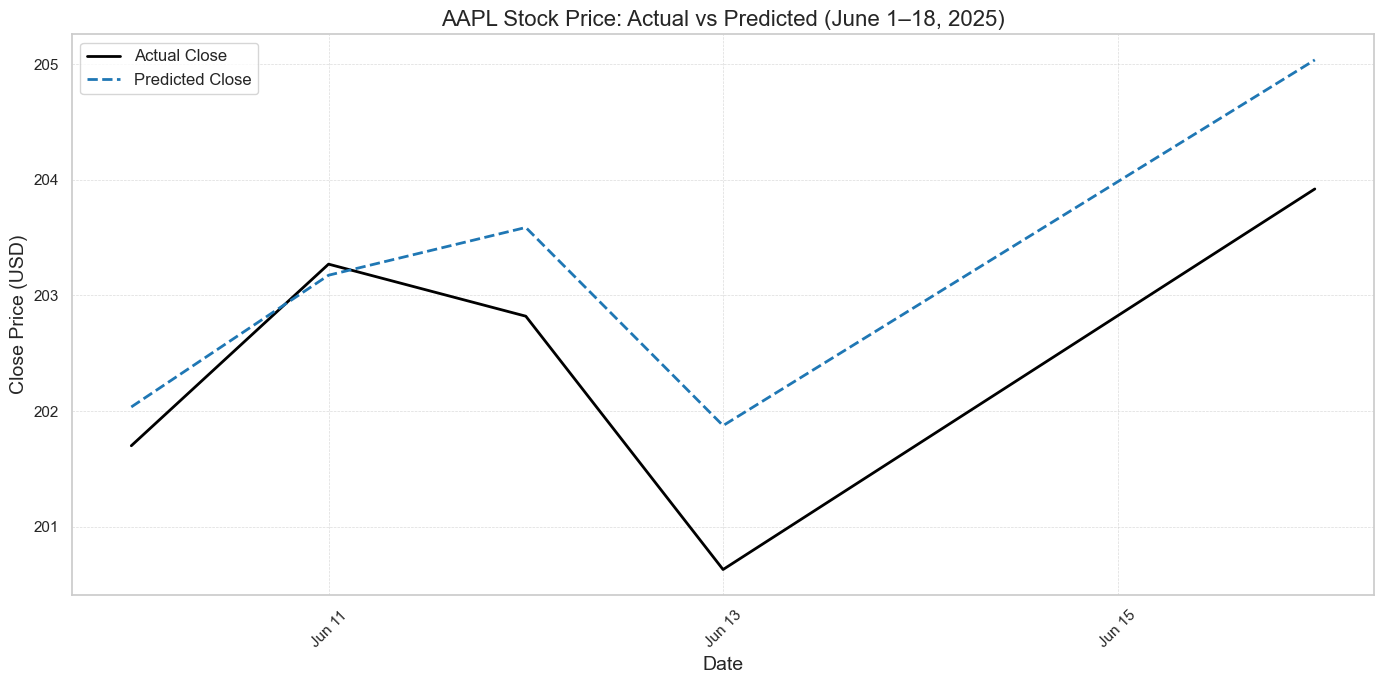

In [ ]:
final_pred = final_pred[:len(test_df)]

dates = test_df.index[:len(final_pred)]

plt.figure(figsize=(14,7))
plt.plot(dates, y_test[:len(final_pred)], label='Actual Close', color='black', linewidth=2)
plt.plot(dates, final_pred, label='Predicted Close', color='tab:blue', linestyle='--', linewidth=2)

plt.title('AAPL Stock Price: Actual vs Predicted (June 1–18, 2025)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price (USD)', fontsize=14)

plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This code visualizes how well our model predicted Apple's stock prices compared to the actual closing prices for June 1–18, 2025.

We plot the actual closing prices as a solid black line and the predicted prices as a dashed blue line. The plot includes clear axis labels and a title to make it easy to understand. 

Gridlines are added with subtle styling to keep the chart clean and professional, mimicking typical finance charts. The x-axis dates are formatted to show every other day for better readability, with labels rotated for clarity.

This visualization helps us quickly see where the model does well and where predictions might deviate from reality.

# ✍ Conclusions

Alright, so after all the modeling and tweaking, we saw some pretty promising results! Our models didn’t just memorize the training data but actually generalized well to new, unseen stock prices (which is key for any real-world prediction).

Of course, stock markets are tricky and noisy, so this model is **not** perfect, but this approach shows how combining different techniques and careful feature engineering can boost performance. Feel free to experiment more, try different features or models, and see where you can push the accuracy.